<em> Code for Section 4., <b>Implementation</b> </em>

Comparison Random Sampling and LHS with 50 samples

In [1]:
# Imports

import numpy as np
import torch
import matplotlib.pyplot as plt
import pyDOE

In [2]:
# Suppress warnings 

import warnings
from botorch.exceptions import InputDataWarning, OptimizationWarning

warnings.filterwarnings("ignore", category=InputDataWarning)

warnings.filterwarnings("ignore", category=OptimizationWarning)

warnings.filterwarnings("ignore", category=RuntimeWarning)

In [3]:
# Latin Hypercube Sampling 

def latin_hypercube_sampling(n_samples, dim, bounds):
    lhs_samples = pyDOE.lhs(dim, samples=n_samples)
    lhs_samples = np.clip(lhs_samples, 0, 1)
    bounds_np = np.array(bounds)
    scaled_samples = lhs_samples * (bounds_np[1] - bounds_np[0]) + bounds_np[0]

    return torch.tensor(scaled_samples, dtype=torch.float64)

In [4]:
# Setting parameters

n_samples = 50
dim = 2
bounds = [0, 1]

In [5]:
# Definition of samples

lhs_samples = latin_hypercube_sampling(n_samples, dim, bounds)

random_samples = torch.rand(n_samples, dim)

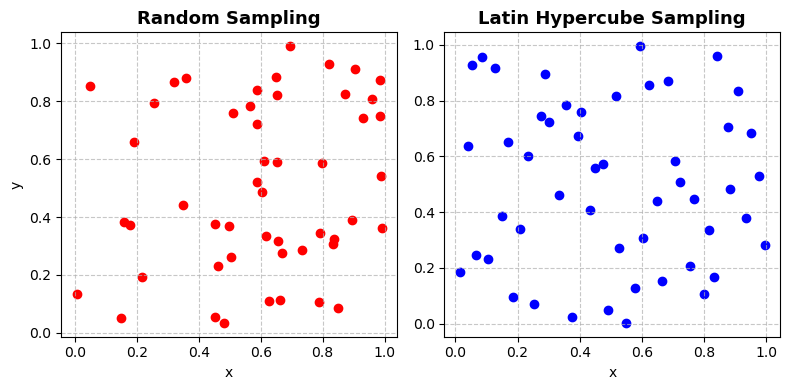

In [6]:
# Plotting

plt.figure(figsize=(8, 4))

plt.subplot(121)
plt.scatter(random_samples[:, 0], random_samples[:, 1], c='red', label='Random')
plt.title('Random Sampling',fontsize=13, fontweight='bold')
plt.xlabel('x')
plt.ylabel('y')
plt.grid(True, linestyle='--', alpha=0.7)

plt.subplot(122)
plt.scatter(lhs_samples[:, 0], lhs_samples[:, 1], c='blue', label='LHS')
plt.title('Latin Hypercube Sampling', fontsize=13, fontweight='bold')
plt.xlabel('x')
plt.grid(True, linestyle='--', alpha=0.7)


plt.tight_layout()
plt.show()

Comparison of Random Sampling and LHS in cBO

In [7]:
# Imports

from botorch.models import SingleTaskGP
from botorch.fit import fit_gpytorch_mll
from gpytorch.mlls import ExactMarginalLogLikelihood
from botorch.optim import optimize_acqf
from botorch.acquisition.analytic import LogConstrainedExpectedImprovement
from botorch.models.model_list_gp_regression import ModelListGP
from gpytorch.mlls import SumMarginalLogLikelihood

In [8]:
# Definition of functions

# Objective function 
def objective_function(x):
    return -(x[...,0]-2)**2 - (x[...,1]-3)**2 # -(x-2)^2-(y-3)^2 


# Constraint function
def constraint_function(x):
    return x[...,0] + x[...,1] - 5 # x+y <= 5 

In [9]:
# Setting parameters
dim = 2
bounds = torch.tensor([[0.0, 0.0], [6.0, 6.0]])

n_initial = 5
n_iterations = 25
batch_size = 1

Random Sampling

In [10]:
# Initialise training data
train_X = bounds[0] + (bounds[1] - bounds[0]) * torch.rand(n_initial, dim, dtype=torch.float64)
train_Y = objective_function(train_X).unsqueeze(-1)
train_C = constraint_function(train_X).unsqueeze(-1)

In [11]:
# Optimisation loop

for i in range(n_iterations):
    
    # Fitting the models
    model_obj = SingleTaskGP(train_X, train_Y)
    model_con = SingleTaskGP(train_X, train_C)
    model = ModelListGP(model_obj, model_con)
    mll = SumMarginalLogLikelihood(model.likelihood, model)
    fit_gpytorch_mll(mll)

    
    # Constrained Expected Improvement
    CEI = LogConstrainedExpectedImprovement(
        model=model,
        best_f=train_Y[train_C.squeeze() <= 0].max(),
        objective_index=0,
        constraints={1: (None, 0)},
    )

    # Optimise the acquisition function
    candidates, _ = optimize_acqf(
        acq_function=CEI,
        bounds=bounds,
        q=batch_size,
        num_restarts=50,
        raw_samples=1024,
    )

    # Evaluate objective and constraint at new candidate point
    new_Y = objective_function(candidates).unsqueeze(-1)
    new_C = constraint_function(candidates).unsqueeze(-1)

    # Append new data to the training data
    train_X = torch.cat([train_X, candidates])
    train_Y = torch.cat([train_Y, new_Y])
    train_C = torch.cat([train_C, new_C])

    # Print progress
    print(f"Iteration {i+1}: Best value so far: {train_Y.max().item()}")

Iteration 1: Best value so far: -1.5269230604171753
Iteration 2: Best value so far: -1.5269230604171753
Iteration 3: Best value so far: -0.4828421473503113
Iteration 4: Best value so far: -0.4828421473503113
Iteration 5: Best value so far: -0.023334287106990814
Iteration 6: Best value so far: -0.023334287106990814
Iteration 7: Best value so far: -0.023334287106990814
Iteration 8: Best value so far: -0.023334287106990814
Iteration 9: Best value so far: -0.023334287106990814
Iteration 10: Best value so far: -0.023334287106990814
Iteration 11: Best value so far: -0.023334287106990814
Iteration 12: Best value so far: -0.023334287106990814
Iteration 13: Best value so far: -0.023334287106990814
Iteration 14: Best value so far: -0.023334287106990814
Iteration 15: Best value so far: -0.023334287106990814
Iteration 16: Best value so far: -0.023334287106990814
Iteration 17: Best value so far: -0.013499516062438488
Iteration 18: Best value so far: -0.0009768832242116332
Iteration 19: Best value s

Total number of points: 30
Number of points inside the feasible region: 25
Best value found: -0.0003357082896400243
Best parameters: [1.981782078742981, 2.998046636581421]


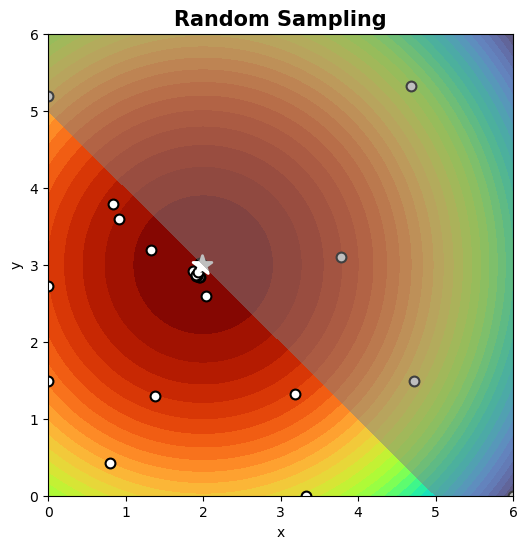

In [12]:
# Grid for plotting
x1 = np.linspace(0, 6, 100)
x2 = np.linspace(0, 6, 100)
X1, X2 = np.meshgrid(x1, x2)
X = torch.from_numpy(np.vstack((X1.ravel(), X2.ravel())).T).float() # np.ravel flattens arrays, np.vstack(...).T stacks flattened arrays + transposes result for plotting
Y = objective_function(X).numpy().reshape(X1.shape)

# Plotting
plt.figure(figsize=(6, 6))

contour = plt.contourf(X1, X2, Y, levels=35, cmap='turbo')
plt.scatter(train_X[:, 0], train_X[:, 1], c='white', edgecolor='black', s=50, label='Evaluated Points', linewidth=1.5)

# Best point
best_idx = train_Y.argmax()
plt.scatter(train_X[best_idx, 0], train_X[best_idx, 1], c='white', s=200, marker='*', label='Best Point', linewidth=2)

# Infeasible region 
Z = constraint_function(X).numpy().reshape(X1.shape)
plt.contourf(X1, X2, Z, levels=[0, Z.max()], colors='gray', alpha=0.5)



total_points = train_X.size(0)
print(f"Total number of points: {total_points}")

feasible_count = torch.sum(constraint_function(train_X).squeeze() <= 0).item()
print(f"Number of points inside the feasible region: {feasible_count}")

print(f"Best value found: {train_Y.max().item()}")
print(f"Best parameters: {train_X[torch.argmax(train_Y)].tolist()}")


plt.title('Random Sampling', fontsize=15, fontweight='bold')
plt.xlabel('x')
plt.ylabel('y')

plt.show()


LHS

In [13]:
# Initialise training data

train_X = latin_hypercube_sampling(n_initial, dim, bounds)
train_Y = objective_function(train_X).unsqueeze(-1)
train_C = constraint_function(train_X).unsqueeze(-1)

In [18]:
# Optimisation loop

for i in range(n_iterations):
    
    # Fit the models
    model_obj = SingleTaskGP(train_X, train_Y)
    model_con = SingleTaskGP(train_X, train_C)
    model = ModelListGP(model_obj, model_con)
    mll = SumMarginalLogLikelihood(model.likelihood, model)
    fit_gpytorch_mll(mll)
    
    # Constrained Expected Improvement
    CEI = LogConstrainedExpectedImprovement(
        model=model,
        best_f=train_Y[train_C.squeeze() <= 0].max(),
        objective_index=0,
        constraints={1: (None, 0)},
    )


    with warnings.catch_warnings():
        warnings.simplefilter("ignore", OptimizationWarning)
        # Optimise the acquisition function
        candidates, _ = optimize_acqf(
            acq_function=CEI,
            bounds=bounds,
            q=batch_size,
            num_restarts=50,
            raw_samples=1024,
        )

    # Evaluate objective and constraint at new candidate point
    new_Y = objective_function(candidates).unsqueeze(-1)
    new_C = constraint_function(candidates).unsqueeze(-1)

    # Append new data to the training data
    train_X = torch.cat([train_X, candidates])
    train_Y = torch.cat([train_Y, new_Y])
    train_C = torch.cat([train_C, new_C])

    # Print progress
    print(f"Iteration {i+1}: Best value so far: {train_Y.max().item()}")

Iteration 1: Best value so far: -3.06951224047225e-05
Iteration 2: Best value so far: -3.06951224047225e-05
Iteration 3: Best value so far: -3.06951224047225e-05
Iteration 4: Best value so far: -3.06951224047225e-05
Iteration 5: Best value so far: -3.06951224047225e-05
Iteration 6: Best value so far: -3.06951224047225e-05
Iteration 7: Best value so far: -3.06951224047225e-05
Iteration 8: Best value so far: -3.06951224047225e-05
Iteration 9: Best value so far: -3.06951224047225e-05
Iteration 10: Best value so far: -3.06951224047225e-05
Iteration 11: Best value so far: -3.06951224047225e-05
Iteration 12: Best value so far: -3.06951224047225e-05
Iteration 13: Best value so far: -3.06951224047225e-05
Iteration 14: Best value so far: -3.06951224047225e-05
Iteration 15: Best value so far: -3.06951224047225e-05
Iteration 16: Best value so far: -9.048416359291878e-06
Iteration 17: Best value so far: -9.048416359291878e-06
Iteration 18: Best value so far: -9.048416359291878e-06
Iteration 19: Be

Total number of points: 80
Number of points inside the feasible region: 78
Best value found: -9.048416359291878e-06
Best parameters: [1.9996623992919922, 2.9970109462738037]


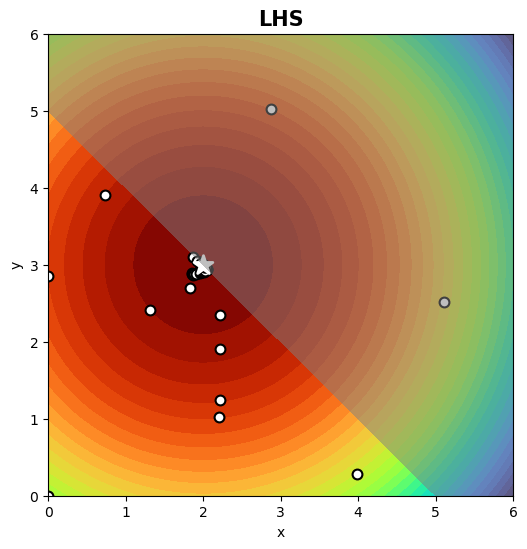

In [19]:
# Grid for plotting
x1 = np.linspace(0, 6, 100)
x2 = np.linspace(0, 6, 100)
X1, X2 = np.meshgrid(x1, x2)
X = torch.from_numpy(np.vstack((X1.ravel(), X2.ravel())).T).float() # np.ravel flattens arrays, np.vstack(...).T stacks flattened arrays + transposes result for plotting
Y = objective_function(X).numpy().reshape(X1.shape)

# Plotting
plt.figure(figsize=(6, 6))

contour = plt.contourf(X1, X2, Y, levels=35, cmap='turbo')
plt.scatter(train_X[:, 0], train_X[:, 1], c='white', edgecolor='black', s=50, label='Evaluated Points', linewidth=1.5)

# Best point
best_idx = train_Y.argmax()
plt.scatter(train_X[best_idx, 0], train_X[best_idx, 1], c='white', s=200, marker='*', label='Best Point', linewidth=2)

# Infeasible region 
Z = constraint_function(X).numpy().reshape(X1.shape)
plt.contourf(X1, X2, Z, levels=[0, Z.max()], colors='gray', alpha=0.5)



total_points = train_X.size(0)
print(f"Total number of points: {total_points}")

feasible_count = torch.sum(constraint_function(train_X).squeeze() <= 0).item()
print(f"Number of points inside the feasible region: {feasible_count}")

print(f"Best value found: {train_Y.max().item()}")
print(f"Best parameters: {train_X[torch.argmax(train_Y)].tolist()}")


plt.title('LHS', fontsize=15, fontweight='bold')
plt.xlabel('x')
plt.ylabel('y')

plt.show()
